In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import cv2 
import utils 

%matplotlib inline 

# Clustering 
Using clustering to identify a smaller set of points for prediction.  Turn the regression problem into a classification problem.  

## Data wrangling 

In [2]:
import glob 

filenames = glob.glob('data/beach_with_tree/*.jpg')
filenames

['data/beach_with_tree\\tree01.jpg',
 'data/beach_with_tree\\tree02.jpg',
 'data/beach_with_tree\\tree03.jpg',
 'data/beach_with_tree\\tree04.jpg',
 'data/beach_with_tree\\tree05.jpg']

`imgs` is a list of all utils.Image objects from the above list 

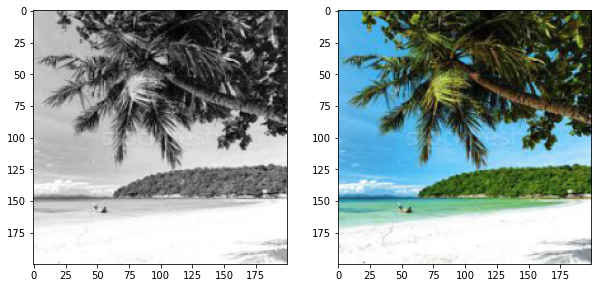

In [3]:
dim = 200
padding = 55

imgs = []

for idx, file in enumerate(filenames): 
    imgs.append(utils.Image(filenames[idx], resize=dim, padding=padding))

    
fig, axes = plt.subplots(1, 2, figsize=(10, 20))
axes[0].imshow(-imgs[0].gray_nopadding, cmap=plt.get_cmap('Greys'))
axes[1].imshow(cv2.cvtColor(imgs[0].data_nopadding, cv2.COLOR_BGR2RGB))

## Identify cluster using kmeans 

In [4]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [5]:
img = imgs[0].data_nopadding/255
n_colors = 32


w, h, d = tuple(img.data.shape)

image_array = np.reshape(img, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0)

kmeans = KMeans(n_clusters=n_colors, random_state = 0, verbose=0).fit(image_array_sample)

In [6]:
clusters  = kmeans.cluster_centers_

clusters = np.array(clusters)

indeces_of_nearest_cluster = kmeans.predict(image_array)
indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))

In [7]:
new_image  = np.zeros(shape = (w,h,d))
for row in range(w):
    for col in range(h):
        new_image[row, col, 0] = clusters[indeces_of_nearest_cluster[row, col], 0]
        new_image[row, col, 1] = clusters[indeces_of_nearest_cluster[row, col], 1]
        new_image[row, col, 2] = clusters[indeces_of_nearest_cluster[row, col], 2]
        
        
new_image = (new_image*255).astype('uint8')

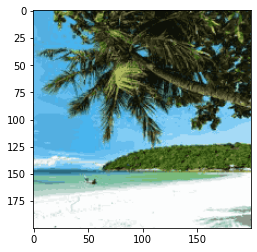

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

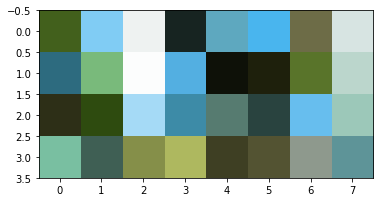

In [9]:
colors = (clusters*255).reshape(4, -1, 3).astype('uint8')
plt.imshow(cv2.cvtColor(colors, cv2.COLOR_BGR2RGB))

## Converting RGB to one-hot encoding 
Do this for all images in `imgs` list 

In [12]:
y = [] 

for img in imgs: 

    img = img.data_nopadding/255

    w, h, d = tuple(img.data.shape)

    image_array = np.reshape(img, (w * h, d))
    
    indeces_of_nearest_cluster = kmeans.predict(image_array)
    indeces_of_nearest_cluster = np.reshape(indeces_of_nearest_cluster, (w, h))
    
    utils.get_onehotencoding_vectors(indeces_of_nearest_cluster, n_colors, y) 
       

y = np.array(y)

w_size=7
X, _ = utils.imgs_to_dataset(filenames, resize=dim, padding=padding, window_size=w_size)

In [13]:
X.shape, y.shape

((200000, 49), (200000, 32))

train, test split 

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=2019)

In [15]:
X_train.shape, y_train.shape

((198000, 49), (198000, 32))

## Model building 

In [16]:
from tensorflow.keras.layers import Dense, InputLayer

In [20]:
model = tf.keras.Sequential([ 
    Dense(100, input_shape=(w_size**2, ), activation='sigmoid'), 
    Dense(50, activation='relu'), 
    Dense(n_colors, activation='softmax')
])


In [35]:
opt = tf.keras.optimizers.SGD()
# opt = tf.keras.optimizers.Adam()

model.compile(optimizer=opt, loss='categorical_crossentropy')  

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               5000      
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1632      
Total params: 11,682
Trainable params: 11,682
Non-trainable params: 0
_________________________________________________________________


In [36]:
EPOCHS=50 

history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    validation_split=0.1, 
                    # callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)],
                    verbose=2)

Train on 178200 samples, validate on 19800 samples
Epoch 1/50
178200/178200 - 5s - loss: 3.0320 - val_loss: 3.0051
Epoch 2/50
178200/178200 - 4s - loss: 2.9863 - val_loss: 2.9593
Epoch 3/50
178200/178200 - 5s - loss: 2.9621 - val_loss: 3.0115
Epoch 4/50
178200/178200 - 4s - loss: 2.9482 - val_loss: 2.9395
Epoch 5/50
178200/178200 - 4s - loss: 3.0280 - val_loss: 3.0121
Epoch 6/50
178200/178200 - 4s - loss: 3.0159 - val_loss: 3.0042
Epoch 7/50
178200/178200 - 4s - loss: 2.9961 - val_loss: 2.9421
Epoch 8/50
178200/178200 - 4s - loss: 2.9280 - val_loss: 2.9288
Epoch 9/50
178200/178200 - 4s - loss: 2.9171 - val_loss: 2.8989
Epoch 10/50
178200/178200 - 4s - loss: 2.8880 - val_loss: 2.8511
Epoch 11/50
178200/178200 - 4s - loss: 2.9035 - val_loss: 2.8702
Epoch 12/50
178200/178200 - 4s - loss: 2.9185 - val_loss: 2.9089
Epoch 13/50
178200/178200 - 4s - loss: 2.9029 - val_loss: 2.9139
Epoch 14/50
178200/178200 - 4s - loss: 2.9028 - val_loss: 2.8626
Epoch 15/50
178200/178200 - 5s - loss: 2.9028 - 

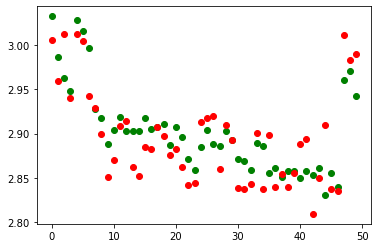

In [37]:
l = history.history['loss']
l_v = history.history['val_loss']


x_ = np.arange(len(l))
plt.scatter(x_, l, c='g') 
plt.scatter(x_, l_v, c='r') 

## Test on image 

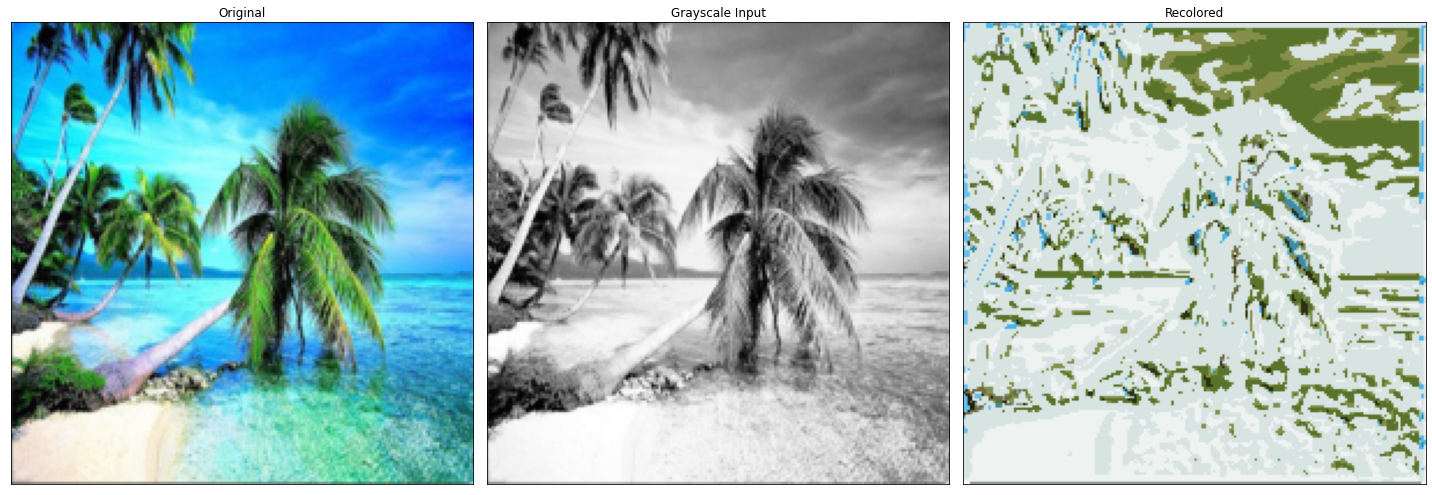

In [38]:
img = imgs[1]
# img = utils.Image('data/beach/beach04.jpg', resize=dim, padding=50) 

X_test = []

for i in range(dim): 
    for j in range(dim): 

        i_ = i + img.padding
        j_ = j + img.padding

        grays, b, g, r = img.get_dataset_for_pixel(i_, j_, window_size=w_size)
        X_test.append(grays)
X_test = np.array(X_test)
X_test = utils.normalize(X_test)
y_model = model.predict(X_test)



new_image  = np.zeros(shape = (y_model.shape[0], 3))

for i in range(y_model.shape[0]):              
    new_image[i] = clusters[np.argmax(y_model[i, :])]
        
new_image = (new_image*255).astype('uint8')
new_image = new_image.reshape(dim, dim, 3)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(cv2.cvtColor(img.data_nopadding, cv2.COLOR_BGR2RGB))
ax[1].imshow(-img.gray_nopadding, cmap=plt.get_cmap('Greys'))
ax[2].imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

ax[0].set_title('Original')
ax[1].set_title('Grayscale Input')
ax[2].set_title('Recolored')

for a in ax: 
  a.axes.xaxis.set_visible(False)
  a.axes.yaxis.set_visible(False)

plt.tight_layout()